#  Data science of climate change - C02 analysis

Gloria Benoit and Pierre Poulain (2023).

- This project aims to study climate change, from original data sources to the reproduction of scientific graphics.
- This notebook focuses specifically on the analysis of atmospheric CO2.

## Data source

### National Oceanic and Atmospheric Administration (NOAA)
[NOAA](https://www.noaa.gov/about-our-agency) is an agency of the U.S. department of commerce that “enriches life through science”. They work to keep the public informed of the changing environment around them. In 1972, they've created [The Global Monitoring Laboratory](https://gml.noaa.gov/) (GML), as part of the NOAA Environmental Research Laboratories. It's mission is focused on geophysical monitoring for climatic change.

GML conducts research that addresses three major challenges: greenhouse gas and carbon cycle feedbacks, changes in clouds, aerosols, and surface radiation, and recovery of stratospheric ozone. One of four programs created by GML is the [Carbon Cycle Greenhouse Gases](https://gml.noaa.gov/ccgg/) (CCGG), in which the spatial and temporal distributions of greenhouse gases are measured and modeled. 

The CCGG research area operates the [Global Greenhouse Gas Reference Network](https://gml.noaa.gov/ccgg/ggrn.php), measuring the atmospheric distribution and trends of the three main long-term drivers of climate change, carbon dioxide (CO2), methane (CH4), and nitrous oxide (N2O), as well as carbon monoxide (CO) which is an important indicator of air pollution.

### CO2 measurements since the 70s

Greenhouse gases are also measured at four Atmospheric Baseline Observatories and multiple tall towers in the United States. It first began measurements of CO2 at the observatories in 1973. Continuous in-situ measurements of these gases provide great detail in their long-term trends, seasonal and short-term variations, and diurnal cycles.

This data can also be found in [GML's CO2 database](https://gml.noaa.gov/aftp/data/trace_gases/co2/in-situ/surface/). 

### CO2 estimates before real measurements, paleoclimatology

The most direct method of investigating past variations of the atmospheric CO2 concentration before 1958, when continuous direct atmospheric CO2 measurements started, is the analysis of air extracted from suitable ice cores ([Siegenthaler et al., 2005](https://doi.org/10.1594/PANGAEA.728135))

The [measurement](https://www.scientificamerican.com/article/how-are-past-temperatures/) of the gas composition is direct: trapped in deep ice cores are tiny bubbles of ancient air, which we can extract and analyze using mass spectrometers. 

#### From 1000 to 2004
In 2010, pre-industrial CO2 data was estimated using two ice cores. Measurements for Law Dome (LD) and Dronning Maud Land (DML) were
sufficient to yield smoothed, with 50-year splines, estimates for CO2 evolution between 1000 and 2004 ([Frank et al., 2010](https://pubmed.ncbi.nlm.nih.gov/20110999/)).

This data can be found in NOAA's Paleoclimatology database, as study [10437](https://www.ncei.noaa.gov/access/paleo-search/study/10437).

#### 800,000 years before present
In 2008, two years prior, the Antarctic Vostok and EPICA Dome C ice cores had provided a composite record of atmospheric carbon dioxide levels over the past 800,000 years ([Lüthi et al., 2008](https://pubmed.ncbi.nlm.nih.gov/18480821/)).

This data can also be found in NOAA's Paleoclimatology database, as study number [6091](https://www.ncei.noaa.gov/access/paleo-search/study/6091).

### Unit of measurement

When measuring gases the term *concentration* is used to describe the amount of gas by volume in the air. The two most common units of measurement are parts-per-million, and percent concentration. All data studied here uses parts-per-million as its unit of measurement.

Parts-per-million (abbreviated ppm) is the [ratio](https://www.co2meter.com/fr-fr/blogs/news/15164297-co2-gas-concentration-defined) of one gas to another. For example, 1,000 ppm of CO2 means that if one could count a million gas molecules, 1,000 of them would be of carbon dioxide and 999,000 molecules would be of some other gases.

## Modules import

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from scipy import stats

## In situ (1973-2022) data analysis

The dataset is stored in a text format, uses spaces as the separator and contains 20 columns for 593 lines. It contains a
site code, which refers to the observatory where the data was recorded, the date, from the year down to
the second, the value of the CO2 measurement and other attributes of the measurements.

Therefore, we have four different datasets, each specific to a given observatory:

| Barrow | Mauna Loa | American Samoa | South Pole |
|:-:|:-:|:-:|:-:|
| BRW | MLO | SMO | SPO |

Their locations can be found directly on [GML's site](https://gml.noaa.gov/dv/site/?program=ccgg&active=1), where in situ observatories are marked by a blue rectangle.

### Collect data

In [2]:
def download_data(url, filename):
    """Download data file."""
    if not Path(filename).is_file():
        request = requests.get(url, allow_redirects=True)
        open(filename, "wb").write(request.content)
        print(f"Downloaded: {filename}")
    else:
        print(f"File already downloaded: {filename}")

In [3]:
observatories = {"brw": "Barrow",
                 "mlo": "Mauna Loa",
                 "smo": "American Samoa",
                 "spo": "South Pole"}
for obs_name in observatories:
    filename = f"co2_{obs_name}_surface-insitu_1_ccgg_MonthlyData.txt"
    url = (
        "https://gml.noaa.gov/aftp/data/trace_gases/co2/in-situ/"
        f"surface/txt/{filename}"
    )
    download_data(url, filename)

File already downloaded: co2_brw_surface-insitu_1_ccgg_MonthlyData.txt
File already downloaded: co2_mlo_surface-insitu_1_ccgg_MonthlyData.txt
File already downloaded: co2_smo_surface-insitu_1_ccgg_MonthlyData.txt
File already downloaded: co2_spo_surface-insitu_1_ccgg_MonthlyData.txt


### Prepare data

In order to keep our dataframe legible, we will only keep the following columns:

- `datetime`,
- `time_decimal`,
- and `value`.

The file header prvovides some informations related to the `value` column:

```
# value:_FillValue : -999.999
# value:long_name : measured_mole_fraction_of_trace_gas_in_dry_air
# value:units : micromol mol-1
# value:comment : Mole fraction reported in units of micromol mol-1 (10-6 mol per mol of dry air); abbreviated as ppm (parts per million).
```

For this column, missing values are coded with `-999.999`

However, if we open the dataset file

In [4]:
df_mlo = pd.read_csv("co2_mlo_surface-insitu_1_ccgg_MonthlyData.txt",
                     comment="#", sep=" ", header=0)

and look closer at the `value` column, we found no occurence of the `-999.999` missing value.

In [5]:
(df_mlo["value"] == -999.999).any()

False

However, we do find a value of `-999.99`, that is not compatible with a real concentration of CO2 in the atmosphere (CO2 concentration is expected to be a positive number).

In [6]:
df_mlo["value"].min()

-999.99

In [7]:
len(df_mlo[ df_mlo["value"] == -999.99 ])

11

Contrary to what is written in the header, missing values are coded as `-999.99`. We will take care of this while loading the data file.

In [8]:
def read_noaa_data(filename):
    """
    Read a dataframe from a NOAA measurement file.
    
    Take care of missing values and column data type."""
    df = pd.read_csv(filename,
                     comment="#",
                     sep=" ",
                     header=0,
                     na_values=-999.99)
    # Keep a subset of columns.
    df = df[["datetime", "time_decimal", "value"]]
    # Convert datetime to real datetime
    df["datetime"] = pd.to_datetime(df["datetime"])
    print(f"Read {filename}: {df.shape[0]} lines x {df.shape[1]} columns")
    return df

In [9]:
filename = "co2_mlo_surface-insitu_1_ccgg_MonthlyData.txt"
df_mlo = read_noaa_data(filename)

Read co2_mlo_surface-insitu_1_ccgg_MonthlyData.txt: 593 lines x 3 columns


Here is a quick view of our data:

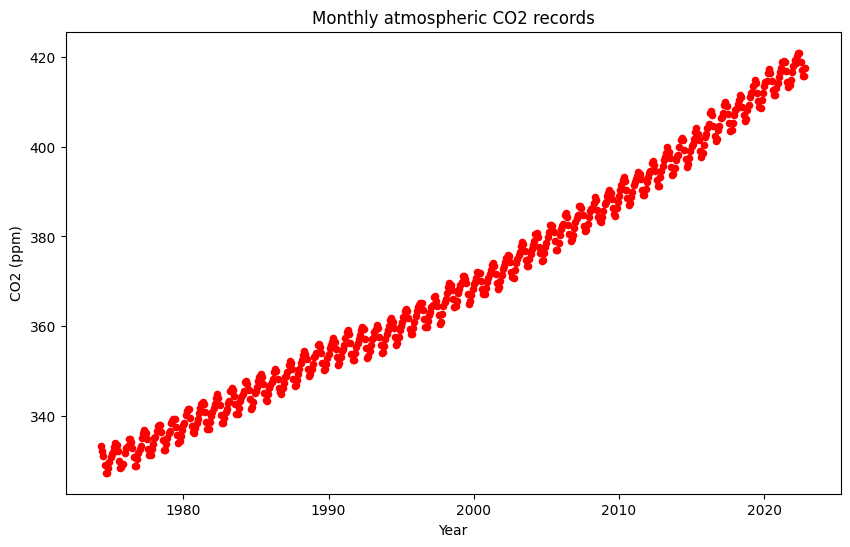

In [10]:
df_mlo.plot(
    kind="scatter",
    x="datetime",
    y="value",
    color="red",
    title="Monthly atmospheric CO2 records",
    xlabel="Year",
    style="-o",
    ylabel="CO2 (ppm)",
    figsize=(10, 6)
);

We have a lot of variations due to the seasonal (winter / summer) cycling.

To smooth the CO2 measurements and remove seasonal variations, we apply a rolling average on the eleven adjacent months.

In [11]:
def add_rolling_average(df):
    """
    Smooth C02 measurements with a 11-month rolling average.
    
    Average on:
    - 5 months before,
    - the actual month,
    - 5 months after.
    """
    df["rolling_mean"] = df["value"].rolling(11, center=True).mean()
    return df

In [12]:
df_mlo = add_rolling_average(df_mlo)
df_mlo.head(15)

,datetime,time_decimal,value,rolling_mean
0,1973-08-01 00:00:00+00:00,1973.580822,NaN,NaN
1,1973-09-01 00:00:00+00:00,1973.665753,NaN,NaN
2,1973-10-01 00:00:00+00:00,1973.747945,NaN,NaN
3,1973-11-01 00:00:00+00:00,1973.832877,NaN,NaN
4,1973-12-01 00:00:00+00:00,1973.915068,NaN,NaN
5,1974-01-01 00:00:00+00:00,1974.000000,NaN,NaN
6,1974-02-01 00:00:00+00:00,1974.084932,NaN,NaN
7,1974-03-01 00:00:00+00:00,1974.161644,NaN,NaN
8,1974-04-01 00:00:00+00:00,1974.246575,NaN,NaN
9,1974-05-01 00:00:00+00:00,1974.328767,333.16,NaN


For MLO (Mauna Loa) observatory, C02 measurements start in May 1974. Due to the rolling average calculated on 11 months, averaged values start in October 1974.

### Aggregate all four observatories

We can now read datasets for the four observatories and aggregate all data into one dataframe.

In [13]:
df_noaa = pd.DataFrame(columns=["datetime", "time_decimal", "obs", "value", "rolling_mean"])
for obs_code in observatories:
    filename = f"co2_{obs_code}_surface-insitu_1_ccgg_MonthlyData.txt"
    df_tmp = read_noaa_data(filename)
    df_tmp = add_rolling_average(df_tmp)
    df_tmp["obs"] = obs_code
    if not df_noaa.empty:
        df_noaa = pd.concat([df_noaa, df_tmp], axis=0, ignore_index=True)
    else:
        df_noaa = df_tmp

Read co2_brw_surface-insitu_1_ccgg_MonthlyData.txt: 593 lines x 3 columns
Read co2_mlo_surface-insitu_1_ccgg_MonthlyData.txt: 593 lines x 3 columns
Read co2_smo_surface-insitu_1_ccgg_MonthlyData.txt: 588 lines x 3 columns
Read co2_spo_surface-insitu_1_ccgg_MonthlyData.txt: 588 lines x 3 columns


Display a few random rows from the NOAA dataset: 

In [14]:
df_noaa.sample(10)

,datetime,time_decimal,value,rolling_mean,obs
1885,1983-04-01 00:00:00+00:00,1983.246575,339.91,NaN,spo
148,1985-12-01 00:00:00+00:00,1985.915068,350.24,347.729091,brw
2269,2015-04-01 00:00:00+00:00,2015.246575,396.39,396.851818,spo
1243,1978-10-01 00:00:00+00:00,1978.747945,NaN,NaN,smo
1567,2005-10-01 00:00:00+00:00,2005.747945,378.54,378.993636,smo
697,1982-04-01 00:00:00+00:00,1982.246575,343.89,341.584545,mlo
2164,2006-07-01 00:00:00+00:00,2006.495890,378.98,378.956364,spo
1010,2008-05-01 00:00:00+00:00,2008.330601,388.78,385.767273,mlo
558,2020-02-01 00:00:00+00:00,2020.084699,420.25,415.660000,brw
2265,2014-12-01 00:00:00+00:00,2014.915068,396.02,396.065455,spo


### Visualize CO2 variations versus time for all four observatories

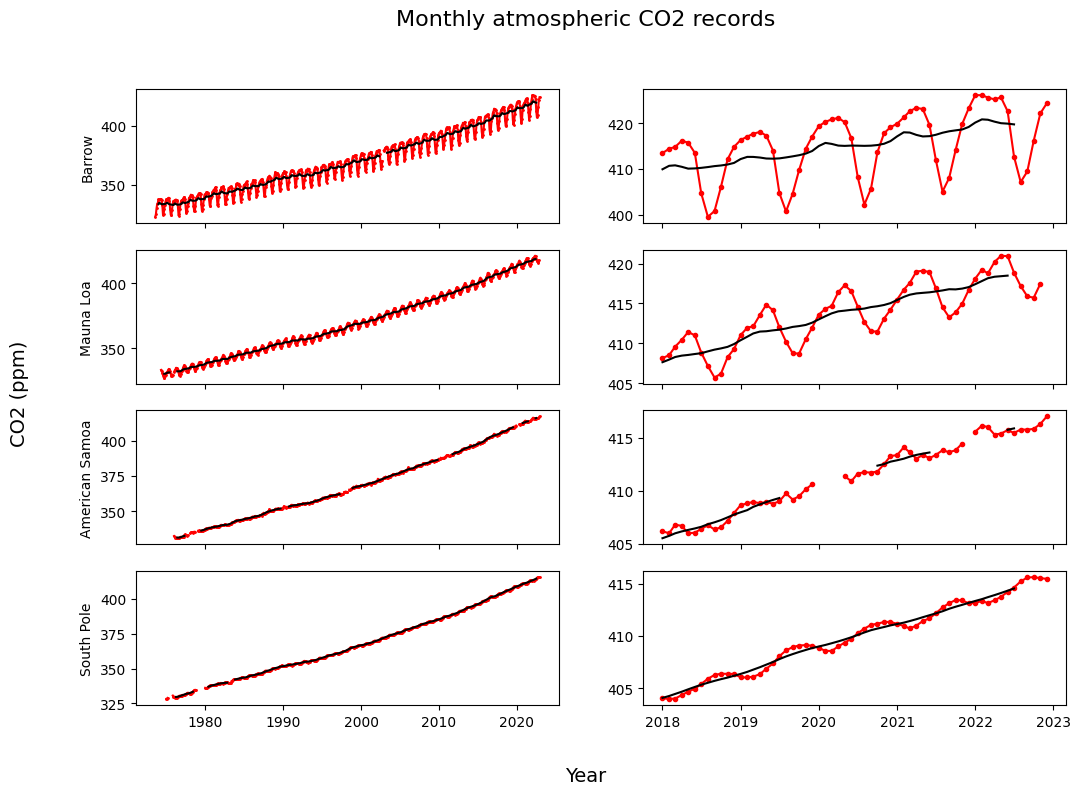

In [15]:
fig, axs = plt.subplots(4, 2, figsize=(12, 8), sharex="col")
axes = [[0, 0], [0, 1], [1, 0], [1, 1], [2, 0], [2, 1], [3, 0], [3, 1]]
fig.suptitle("Monthly atmospheric CO2 records", fontsize=16)

position = 0
for obs_code in observatories:
    # Select data for a given observatory.
    df = df_noaa[ df_noaa["obs"] == obs_code ]
    
    # First plot: from 1973 to 2022.
    i, j = axes[position]
    axs[i,j].plot(df["datetime"], df["value"],
                  "-o", color="red", markersize=1)
    axs[i,j].plot(df["datetime"], df["rolling_mean"],
                  color="black")
    axs[i,j].set_ylabel(observatories[obs_code])

    # Second plot: last five years.
    start_year = max(df["datetime"].dt.year) - 5
    df = df[ df["datetime"].dt.year > start_year ]
    i, j = axes[position+1]
    axs[i,j].plot(df["datetime"], df["value"],
                  "-o", color="red", markersize=3)
    axs[i,j].plot(df["datetime"], df["rolling_mean"],
                  color="black")
    position += 2

fig.supxlabel("Year", fontsize=14)
fig.supylabel("CO2 (ppm)", fontsize=14)
plt.show()

- Raw measurements are displayed in red.
- Rolling averages are shown in black. Averaged values remove seasonal variations.
- Horizontal panels represent observatories.
- Vertical panels are different time frames: 1973-2022 on the left panels, 2018-2022 on the right panels. 

### Forecast CO2 evolution for Mauna Loa

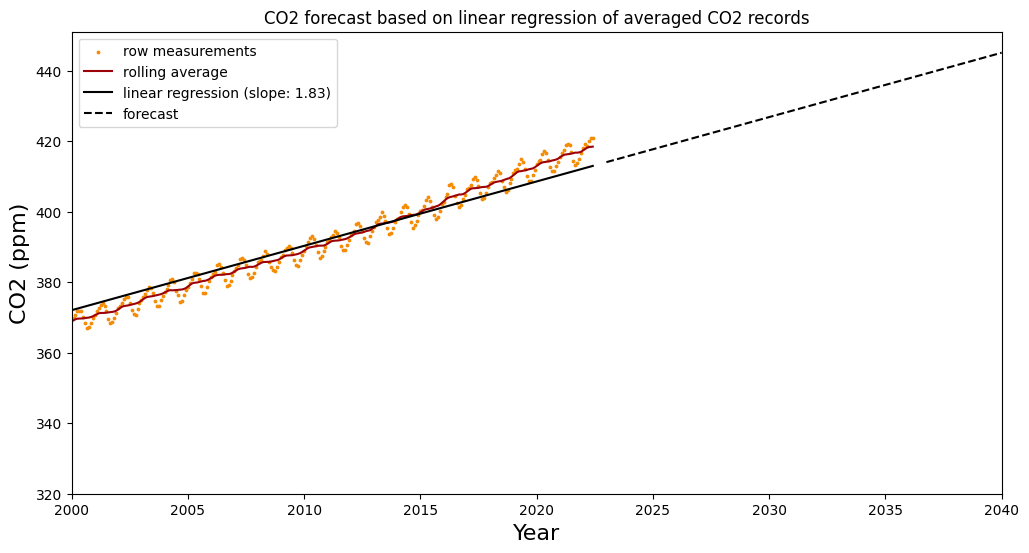

In [16]:
color_palette = ["#9d0208", "#dc2f02", "#f48c06", "#ffba08"]
# predictions = pd.DataFrame(list(range(2023, 2051)))
target_year = 2040
predictions = np.arange(2023, target_year+1)
fig, ax = plt.subplots(figsize=(12, 6))

# Select data for a given observatory.
df = df_noaa[ df_noaa["obs"] == "mlo" ]

# Remove missing values for the linear regression
df = df.dropna()
# Make linear regression.
lin_res = stats.linregress(df["time_decimal"], df["rolling_mean"])

# Display results.
ax.scatter(df["time_decimal"],
           df["value"],
           color="#f48c06",
           s=3,
           label="row measurements"
)
ax.plot(df["time_decimal"],
        df["rolling_mean"],
        color="#9d0208",
        label="rolling average"
)
ax.plot(df["time_decimal"],
        lin_res.intercept + lin_res.slope*df["time_decimal"],
        color="black",
        label=f"linear regression (slope: {lin_res.slope:.2f})"
)
ax.plot(predictions,
        lin_res.intercept + lin_res.slope * predictions,
        color="black", linestyle='--',
        label="forecast"
)

ax.set_xlim([2000, target_year])
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("CO2 (ppm)", fontsize=16)
ax.legend(loc="upper left")
ax.set_title("CO2 forecast based on linear regression of averaged CO2 records");

## Paleoclimatology data analysis

### 1000 to 2004 (ice cores)

#### Collect data

The dataset is stored:
- in a text format,
- uses tabulations as the separator,
- and contains 23 columns and 1005 lines.

It contains the year of recording, from 1000 to 2004, and three mains values: 
- the record at Law Dome (`LD`),
- the record at Dronning Maud Land (`DML`)
- and the average record over those two sites (`ALL`).

Additional columns are provided with values smoothed with splines ranging from 50 to 200 years with a 25-year step.

In [17]:
filename = "smoothedco2.txt"
url = f"https://www.ncei.noaa.gov/pub/data/paleo/contributions_by_author/frank2010/{filename}"
download_data(url, filename)

df_icecore = pd.read_csv(filename, sep="\t", header=0)
df_icecore.head()

File already downloaded: smoothedco2.txt


,Year,ALL_50_full,LD_050,DML_050,ALL_050,LD_075,DML_075,ALL_075,LD_100,DML_100,...,ALL_125,LD_150,DML_150,ALL_150,LD_175,DML_175,ALL_175,LD_200,DML_200,ALL_200
0,1000,278.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001,278.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1002,278.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1003,278.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1004,278.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Preparation data

It looks like there are many missing values.

In [18]:
df_icecore.isna().sum()

Year             0
ALL_50_full      0
LD_050         254
DML_050        254
ALL_050        254
LD_075         254
DML_075        254
ALL_075        254
LD_100         254
DML_100        254
ALL_100        254
LD_125         254
DML_125        254
ALL_125        254
LD_150         254
DML_150        254
ALL_150        254
LD_175         254
DML_175        254
ALL_175        254
LD_200         254
DML_200        254
ALL_200        254
dtype: int64

Column `ALL_50_full` has no missing data.

We will only take into account, the years and the averaged value for both sites with a 50-year spline.

In [19]:
df_icecore = df_icecore[["Year", "ALL_50_full"]]
df_icecore.describe()

,Year,ALL_50_full
count,1005.000000,1005.000000
mean,1502.000000,284.887801
std,290.262812,14.310892
min,1000.000000,276.450000
25%,1251.000000,279.600000
50%,1502.000000,280.980000
75%,1753.000000,282.100000
max,2004.000000,372.930000


#### Display data from ice core

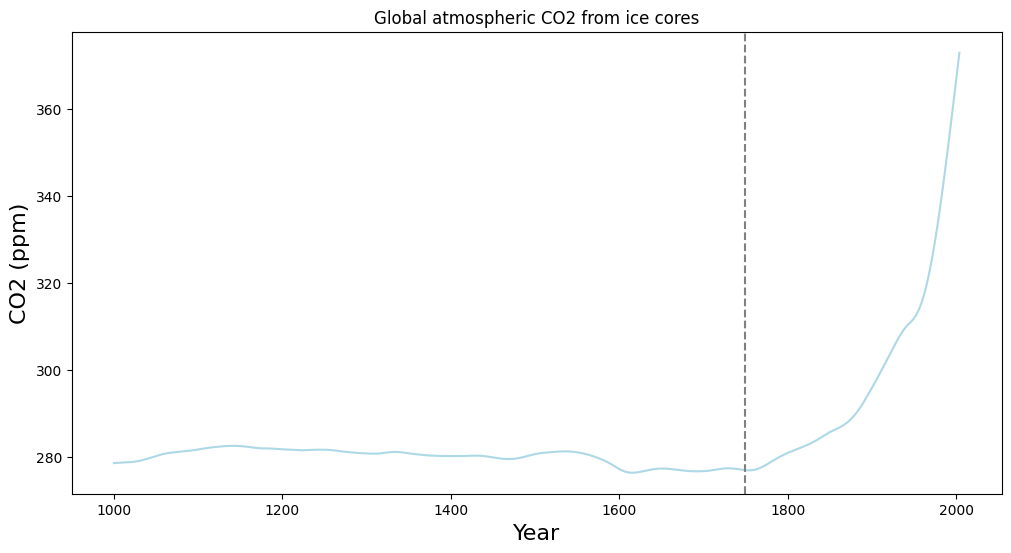

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(df_icecore["Year"],
         df_icecore["ALL_50_full"],
         color="lightblue")
plt.axvline(x=1750, linestyle='--', color="grey")

plt.title("Global atmospheric CO2 from ice cores")
plt.xlabel("Year", fontsize=16)
plt.ylabel("CO2 (ppm)", fontsize=16)
plt.show()

Before 1750, atmospheric CO2 was oscillating around 280 ppm. After 1750, it skyrockets up to 418 ppm in 2022.

### 800,000 years before present

#### Collecte data

The dataset is:
- stored in a text format,
- uses tabulations as the separator
-  and contains 2 columns for 1096 lines.

In [21]:
filename = "edc3-composite-co2-2008-noaa.txt"
url = f"https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/epica_domec/{filename}"
download_data(url, filename)
df_paleo = pd.read_csv(filename, comment='#', sep='\t', header=0)
df_paleo.head()

File already downloaded: edc3-composite-co2-2008-noaa.txt


,gas_ageBP,CO2
0,137,280.4
1,268,274.9
2,279,277.9
3,395,279.1
4,404,281.9


In [22]:
df_paleo.describe()

,gas_ageBP,CO2
count,1096.000000,1096.000000
mean,390905.979015,230.835675
std,262092.947239,27.573616
min,137.000000,171.600000
25%,137133.500000,207.500000
50%,423206.500000,231.450000
75%,627408.000000,251.525000
max,798512.000000,298.600000


#### Prepare data

The `gas_ageBP` column correspond to the number of years before present, meaning [before 1950](https://www.artobatours.com/articles/archaeology/bp-bc-bce-ad-ce-cal-mean/). This means that the first year *137 BP* is actually the year *1813* (1950 - 137 = 1813). We need to shift the year to make a comparison with previsous datasets.

In [23]:
df_paleo["Year"] = 1950 - df_paleo["gas_ageBP"]
df_paleo.head()

,gas_ageBP,CO2,Year
0,137,280.4,1813
1,268,274.9,1682
2,279,277.9,1671
3,395,279.1,1555
4,404,281.9,1546


#### Visualize data

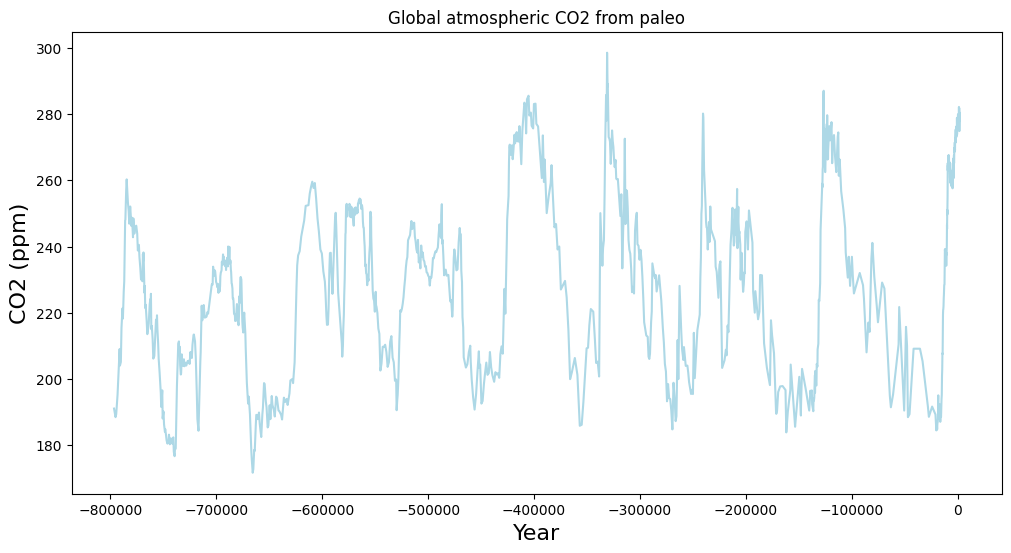

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(df_paleo["Year"],
         df_paleo["CO2"],
         color="lightblue")
plt.title("Global atmospheric CO2 from paleo")
plt.xlabel("Year", fontsize=16)
plt.ylabel("CO2 (ppm)", fontsize=16)
plt.show()

## Compare all datasets

### Aggregate data

First average NOAA values by year (for Mona Loa observatory only). We extract raw and rolling average C02 values for comparison, but we only will keep raw C02 values ultimately.

In [25]:
# Select Mona Loa observatory.
df_all = (df_noaa
 .query("obs == 'mlo'")
 .assign(Year=df_noaa["datetime"].dt.year)
 .groupby("Year")
 .agg(
     CO2=("value", "mean"),
     CO2_rolling=("rolling_mean", "mean"),
 )
 .reset_index()
 .assign(Source="NOAA")
)

In [26]:
df_all.head(10)

,Year,CO2,CO2_rolling,Source
0,1973,NaN,NaN,NOAA
1,1974,329.753750,330.246970,NOAA
2,1975,331.161818,331.001364,NOAA
3,1976,332.039167,332.148831,NOAA
4,1977,333.855833,333.823409,NOAA
5,1978,335.423333,335.427045,NOAA
6,1979,336.836667,336.854773,NOAA
7,1980,338.790000,338.767197,NOAA
8,1981,340.123333,340.145530,NOAA
9,1982,341.475000,341.453712,NOAA


In [27]:
df_all = df_all.drop(["CO2_rolling"], axis=1)
df_all.head()

,Year,CO2,Source
0,1973,NaN,NOAA
1,1974,329.753750,NOAA
2,1975,331.161818,NOAA
3,1976,332.039167,NOAA
4,1977,333.855833,NOAA


Then add ice core values

In [28]:
df = (df_icecore
 .rename(columns={"ALL_50_full": "CO2"})
 .assign(Source="ICECORE")
)

In [29]:
df_all = pd.concat([df_all, df], axis=0, ignore_index=True)

Finally, add paleo values

In [30]:
df = (df_paleo
 .drop("gas_ageBP", axis=1)
 .assign(Source="PALEO")
)
df.head()

,CO2,Year,Source
0,280.4,1813,PALEO
1,274.9,1682,PALEO
2,277.9,1671,PALEO
3,279.1,1555,PALEO
4,281.9,1546,PALEO


In [31]:
df_all = pd.concat([df_all, df], axis=0, ignore_index=True)

In [32]:
df_all.sample(10)

,Year,CO2,Source
1194,-11291,237.60,PALEO
1080,-483,273.90,PALEO
614,1564,280.55,ICECORE
1985,-694767,235.40,PALEO
1283,-114551,262.50,PALEO
1895,-647648,194.80,PALEO
1518,-322330,260.50,PALEO
1098,-2211,271.50,PALEO
1488,-296791,224.40,PALEO
2137,-786083,247.90,PALEO


### Visualize data (full picture)

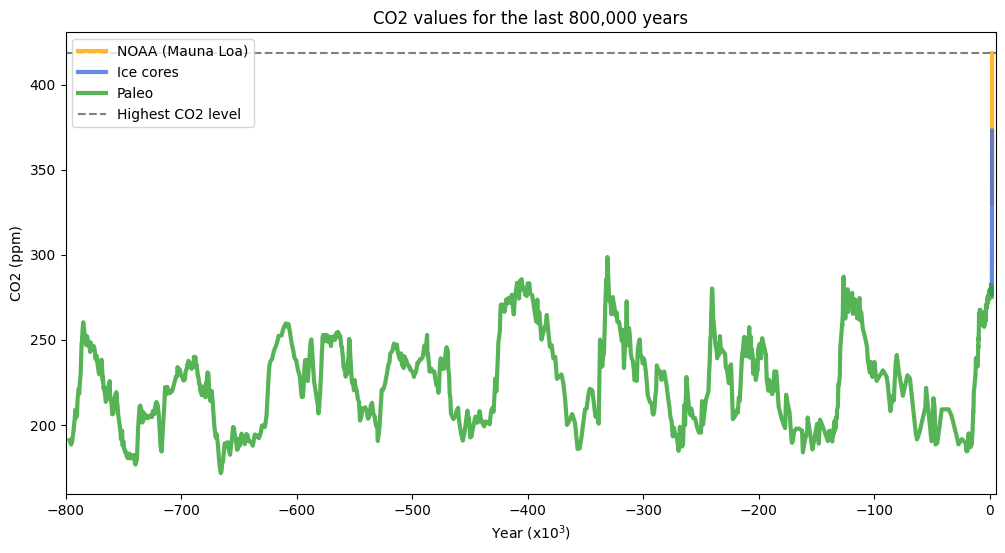

In [33]:
plt.figure(figsize=(12, 6))

sources = ("NOAA", "ICECORE", "PALEO")
names = ("NOAA (Mauna Loa)", "Ice cores", "Paleo")
colors = ("orange", "royalblue", "tab:green")

for source, name, color in zip(sources, names, colors):
    plt.plot(df_all[ df_all["Source"] == source]["Year"]/1000,
             df_all[ df_all["Source"] == source]["CO2"],
             color=color, linewidth=3, label=name, alpha=0.8)

plt.xlim([-800, 5])
plt.title("CO2 values for the last 800,000 years")
plt.xlabel("Year (x$10^3$)")
plt.ylabel("CO2 (ppm)")
max_year = df_all["Year"].max()
max_CO2 =  df_all[ df_all["Year"] == max_year ]["CO2"]
plt.axhline(max_CO2.values[0], linestyle="--", color="gray",
            label="Highest CO2 level")
plt.legend(loc="upper left")
plt.show()

### Visualize data (zoom in)

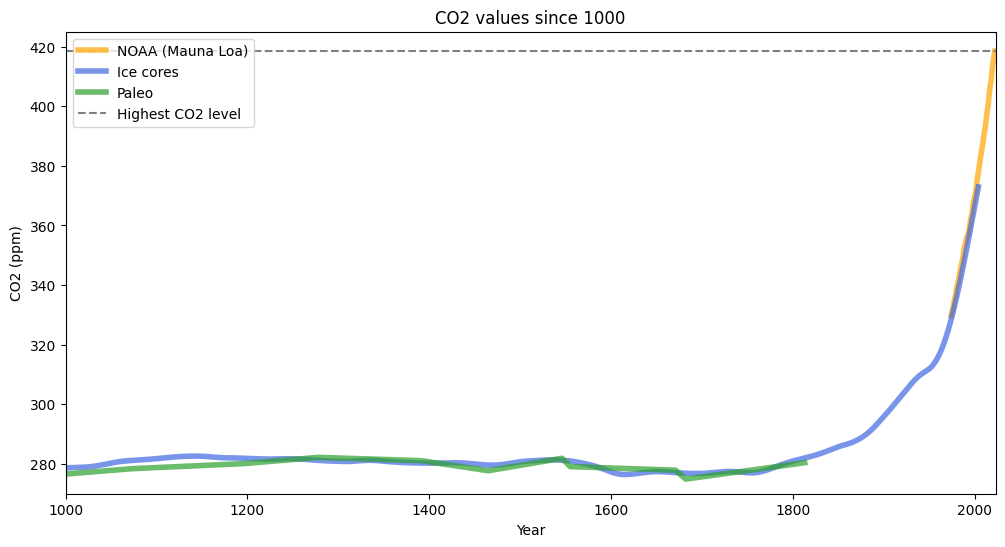

In [34]:
plt.figure(figsize=(12, 6))

start_year = 1000
for source, name, color in zip(sources, names, colors):
    plt.plot(df_all[ (df_all["Source"] == source) & (df_all["Year"] >= start_year) ]["Year"],
             df_all[ (df_all["Source"] == source) & (df_all["Year"] >= start_year) ]["CO2"],
             linewidth=4, color=color, label=name, alpha=0.7)

plt.xlim([start_year, 2023])
plt.ylim([270, 425])
plt.title(f"CO2 values since {start_year}")
plt.xlabel("Year")
plt.ylabel("CO2 (ppm)")
max_year = df_all["Year"].max()
max_CO2 =  df_all[ df_all["Year"] == max_year ]["CO2"]
plt.axhline(max_CO2.values[0], linestyle="--", color="gray",
            label="Highest CO2 level")
plt.legend(loc="upper left")
plt.show()

Even though CO2 values from paleo and ice cores are only estimated values and come from different locations, they are in very good agreement with each other and with values from Mauna Loa (NOAA). 

## Conclusion

Atmospheric CO2 records have been soaring since pre-industrial times (circa 1850).

## Library versions

In [35]:
%load_ext watermark
# Python implementation and version, and machine architecture
%watermark
# Versions for jupyterlab, imported packages and watermark itself
%watermark --packages jupyterlab,ipywidgets --iversions --watermark
# Name of conda environment
%watermark --conda

Last updated: 2024-01-19T16:42:51.538391+01:00

Python implementation: CPython
Python version       : 3.12.0
IPython version      : 8.20.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 6.2.0-39-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

jupyterlab: 4.0.10
ipywidgets: 8.1.1

numpy     : 1.26.3
pandas    : 2.1.4
scipy     : 1.11.4
matplotlib: 3.8.2
requests  : 2.31.0

Watermark: 2.4.3

conda environment: data-science-climate-change

